In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy import corrcoef


In [31]:
mm_df = pd.read_csv('data/paperid_media_metrics.tsv', sep='\t')
cn_df = pd.read_csv('data/paperid_num_citations.txt', sep='\t', names=['id', 'citation'])
meta_df = pd.read_csv('data/paperid_metadata.tsv', sep='\t', names=['id', 'title', 'authors', 'mail_host', 'field', 'abstract'])

In [32]:
# drop non-numerical rows
mm_df['mendeley'] = pd.to_numeric(mm_df['mendeley'], errors='coerce')
mm_df.dropna(axis=0, how='any', inplace=True)

cn_df['citation'] = pd.to_numeric(cn_df['citation'], errors='coerce')
cn_df.dropna(axis=0, how='any', inplace=True)

# merge the two tables
mm_df = pd.merge(mm_df, cn_df, left_on='paperid', right_on='id')
mm_df.drop('id', axis=1, inplace=True)
metric_fields = list(sorted(set(mm_df.columns) - {'paperid'}))
print(mm_df.shape)


(35055, 10)


## Correlattion between altimtric score and other metrics

Interesting fact: 

citation number is negatively correlated with the altimetric score

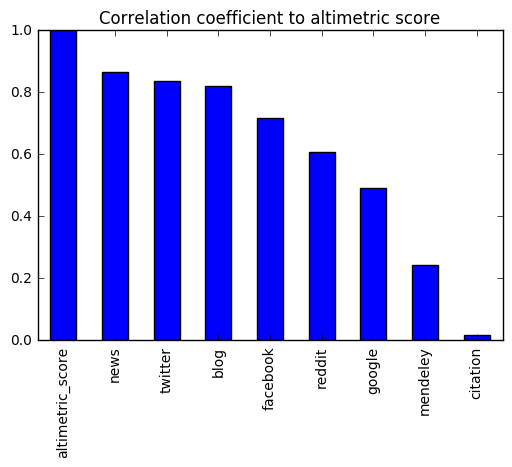

In [15]:
data = mm_df[metric_fields].as_matrix().T
corrmat = pd.DataFrame(corrcoef(data), columns=metric_fields, index=metric_fields)
corrmat['altimetric_score'].sort_values(ascending=False).plot(kind='bar', title='Correlation coefficient to altimetric score')



In [34]:
# some preprocessing for regression model's input

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

meta_df['authors'] = meta_df['authors'].map(lambda s: ' '.join(s.split(';')))

meta_df = pd.merge(meta_df, mm_df, left_on='id', right_on='paperid')
meta_df.drop('paperid', axis=1, inplace=True)
meta_df.fillna(value='', axis=0, inplace=True)
meta_df['field'] = meta_df['field'].map(lambda s: s.replace(',', '_'))
meta_df['authors'] = meta_df['authors'].map(lambda s: s.replace('.', '__'))

if True:  # remove papers without any news citation
    mm_df = mm_df[mm_df['news'] > 0]
    meta_df = meta_df[meta_df['news']  > 0]
    
meta_df.head(2)

,id,title,authors,mail_host,field,abstract,altimetric_score,news,reddit,twitter,mendeley,blog,facebook,google,citation
0,113_29_8284,Vagus nerve stimulation inhibits cytokine prod...,Frieda_A___Koopman Sangeeta_S___Chavan Sanda_M...,amc.uva.nl,Immunology_and_Inflammation,"Rheumatoid arthritis (RA) is a heterogeneous, ...",417,49,1,54,53.0,3,14,3,4.0
1,112_40_12332,"Fatigue-free, superstretchable, transparent, a...",Chuan_Fei_Guo Qihan_Liu Guohui_Wang Yecheng_Wa...,,Physics,Next-generation flexible electronics require h...,116,14,0,2,35.0,3,0,0,6.0


In [37]:
train_cnt = int(meta_df.shape[0] * 7/8)

In [38]:
# split train/test data
train = meta_df.iloc[:train_cnt]
test = meta_df.iloc[train_cnt:]

In [39]:
# convert text to sparse matrices
col2tfidf = {}
text_columns = ['title', 'authors', 'abstract', 'mail_host', 'field']
train_mats = []
test_mats = []
for col in tqdm(text_columns):
    if col in {'mail_host', 'field'}:
        tfidf = TfidfVectorizer(use_idf=False, tokenizer=None)
    else:
        tfidf = TfidfVectorizer(stop_words='english')
    train_mats.append(tfidf.fit_transform(train[col].values))
    test_mats.append(tfidf.transform(test[col].values))
    col2tfidf[col] = tfidf

100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


In [40]:
# concatenate different feature matrices
from scipy.sparse import hstack, vstack
train_X = hstack(train_mats)
test_X = hstack(test_mats)

## Correlation between target variable and different features

The higher the correlation coefficient, the more relevant the feature is to the target variable

Modify the value of `target_variable` to other variables if necessary

In [34]:
from scipy.stats import pearsonr
from joblib import Parallel, delayed

min_df = 50
target_variable = 'news'  # modify this variable if you want to check other target variables

col2tf = {}
text_columns = ['title', 'authors', 'abstract', 'mail_host', 'field']
mats = []
for col in tqdm(text_columns):
    if col in {'mail_host', 'field'}:
        tf = TfidfVectorizer(use_idf=False, tokenizer=None, min_df=min_df)
    else:
        tf = TfidfVectorizer(stop_words='english', use_idf=False, min_df=min_df)  # idf is disabled
    mats.append(tf.fit_transform(meta_df[col].values))
    col2tf[col] = tf
    


100%|██████████| 5/5 [00:11<00:00,  1.76s/it]


In [36]:
# feature_X = train_mats[1]
feature_X = hstack(mats).tocsc()
Y = meta_df[target_variable].values
coefs = Parallel(n_jobs=-1)(delayed(pearsonr)(feature_X[:, i].toarray()[:, 0], Y)
                            for i in range(feature_X.shape[1]))
coefs = np.array(coefs)[:, 0]

In [37]:
indx = []
# for col in text_columns:
for col in text_columns:
    t = col2tf[col] 
    inds = list(t.vocabulary_.values())
    id2word = {v: k for k, v in t.vocabulary_.items()}
    indx += ['{}({})'.format(id2word[i], col) for i in range(np.min(inds), np.max(inds)+1)]    

In [38]:
print(len(indx))
print(len(coefs))

8565
8565


In [53]:
top_k = 15
feature_coef = pd.DataFrame({'name': indx[:len(coefs)], 'coef': coefs})
print('top-{} positively correlated features'.format(top_k))
top_features = feature_coef.sort_values(by='coef', ascending=False).head(top_k)
top_features.set_index('name', inplace=True)
print(top_features.to_latex())

top-15 positively correlated features
\begin{tabular}{lr}
\toprule
{} &      coef \\
name                                              &           \\
\midrule
psychological\_and\_cognitive\_sciences(field)       &  0.154290 \\
health(abstract)                                  &  0.112338 \\
people(abstract)                                  &  0.095245 \\
united(abstract)                                  &  0.080595 \\
earth\_\_atmospheric\_\_and\_planetary\_sciences(field) &  0.080050 \\
sustainability\_science(field)                     &  0.078643 \\
decades(abstract)                                 &  0.077481 \\
2012(abstract)                                    &  0.077478 \\
climate(abstract)                                 &  0.074896 \\
mortality(abstract)                               &  0.074011 \\
century(abstract)                                 &  0.073789 \\
impacts(abstract)                                 &  0.073428 \\
emotional(abstract)                               &

In [28]:
feature_coef.sort_values(by='coef', ascending=False).head(top_k)['name']

298317             theropoda(abstract)
246213      hadrosauriformes(abstract)
272043          ornithischia(abstract)
288832       sauropodomorpha(abstract)
223482          ceratopsidae(abstract)
285054              reigning(abstract)
28643                      tens(title)
102464    jeffrey_t___hancock(authors)
99820      jamie_e___guillory(authors)
32959     adam_d___i___kramer(authors)
210176                 a2338(abstract)
241991                fowler(abstract)
224564            christakis(abstract)
219745                   bmj(abstract)
308617                   fb(mail_host)
Name: name, dtype: object

In [33]:
print('top-{} negatively correlated features'.format(top_k))
feature_coef.sort_values(by='coef', ascending=True).head(top_k)

top-15 negatively correlated features


,coef,name
281325,-0.066890,protein(abstract)
223294,-0.055382,cells(abstract)
223281,-0.052271,cell(abstract)
311016,-0.052199,biochemistry(field)
218859,-0.051087,binding(abstract)
236674,-0.047819,em(abstract)
281343,-0.046148,proteins(abstract)
23448,-0.044305,protein(title)
239368,-0.043854,expression(abstract)
211218,-0.038930,activation(abstract)


## metric value vs item number

Comment: many metrics follow power-law distribution

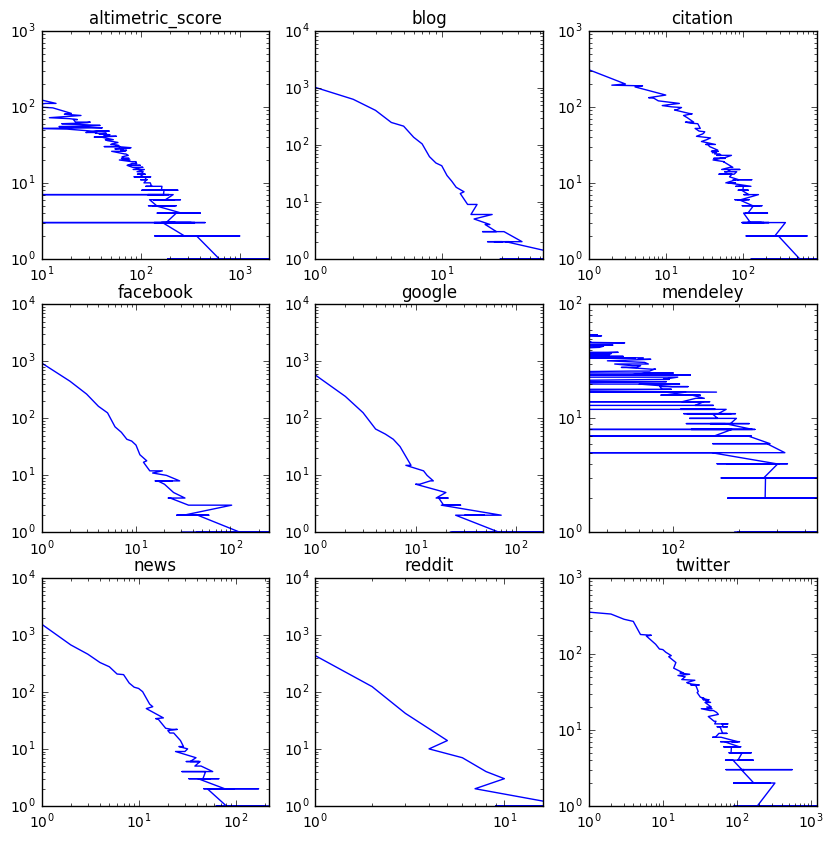

In [45]:
# for each metric, 
# plot the value vs frequency in log-log scale
# most of them seem to be power-law
fig = plt.figure(figsize=(10, 10))
for i, f in enumerate(metric_fields):
    fig.add_subplot(3, 3, i+1)
    freq = train[f].value_counts()
    ax = freq.plot(logx=True, logy=True, title=f)


## predicting metric number

[Train/test score](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score) should be [-1, 1]. The higher the better. 

Comment:

- Lasso performs badly
- RandomForrest model performs better: the more estimators, the better score
- RandomForrest suffers from overfitting

In [41]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [42]:
target_variable = 'news'

scaler = MinMaxScaler()
train_Y = scaler.fit_transform(train[target_variable].values[:, None])[:, 0]
test_Y = scaler.transform(test[target_variable].values[:, None])[:, 0]

models = [Lasso(alpha=0.1),
          Lasso(alpha=0.5),
          LinearRegression(),
          Ridge(alpha=0.1),
          Ridge(alpha=0.5),
          # RandomForestRegressor(n_estimators=4, n_jobs=-1),
          RandomForestRegressor(n_estimators=8, n_jobs=-1),
          RandomForestRegressor(n_estimators=16, n_jobs=-1)]
          # RandomForestRegressor(n_estimators=32, n_jobs=-1)]
rows = []
for clf in models:
    clf.fit(train_X, train_Y)
    print(clf)
    train_score = clf.score(train_X, train_Y)
    test_score = clf.score(test_X, test_Y)
    rows.append((clf, train_score, test_score))
print(rows)    

/home/cloud-user/code/social-media-exposure/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=8, n_jobs=-1, 

In [43]:
df = pd.DataFrame(rows, columns=['Model', 'Train score', 'Test score'])

In [44]:
print(df.to_latex())

\begin{tabular}{llrr}
\toprule
{} &                                              Model &  Train score &  Test score \\
\midrule
0 &  Lasso(alpha=0.1, copy\_X=True, fit\_intercept=Tr... &     0.000000 &   -0.000126 \\
1 &  Lasso(alpha=0.5, copy\_X=True, fit\_intercept=Tr... &     0.000000 &   -0.000126 \\
2 &  LinearRegression(copy\_X=True, fit\_intercept=Tr... &     1.000000 &   -0.162151 \\
3 &  Ridge(alpha=0.1, copy\_X=True, fit\_intercept=Tr... &     0.998688 &   -0.148768 \\
4 &  Ridge(alpha=0.5, copy\_X=True, fit\_intercept=Tr... &     0.976475 &   -0.107353 \\
5 &  (DecisionTreeRegressor(criterion='mse', max\_de... &     0.838206 &   -0.087698 \\
6 &  (DecisionTreeRegressor(criterion='mse', max\_de... &     0.833755 &   -0.082621 \\
\bottomrule
\end{tabular}

